In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import tensorboard
from PIL import Image
import os
from datetime import datetime
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import pickle
from models import Only_Classification_Model, Only_Colorization_Model, Model

In [50]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [51]:
# get data
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(directory="data/ColorfulOriginal/", label_mode="categorical", batch_size=None, shuffle=False, image_size=(128,128), validation_split=0.1, subset="both", crop_to_aspect_ratio=True)

print(train_ds.class_names)
class_names = train_ds.class_names
normalizing_layer = tf.keras.layers.Rescaling(1./255)
flip_layer = tf.keras.layers.RandomFlip()
rotation_layer = tf.keras.layers.RandomRotation((-0.1,0.1))


def preprocess_train(data):

    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (flip_layer(x), y))
    data = data.map(lambda x,y: (rotation_layer(x), y))

    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))
    data = data.map(lambda image, label: ((((tf.expand_dims((image[:,:,0]/200 + 0.5), -1)), ((image[:,:,1:]/200) + 0.5))), label))

    data = data.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

    return data

def preprocess_test(data):
    data = data.map(lambda x,y: (normalizing_layer(x), y))
    data = data.map(lambda x,y: (tfio.experimental.color.rgb_to_lab(x), tf.cast(y, tf.int32)))

    data = data.map(lambda image, label: (((tf.expand_dims((image[:,:,0]/200 + 0.5), -1), ((image[:,:,1:]/200) + 0.5))), label))

    data = data.shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

    return data

train_data = preprocess_train(train_ds)
test_data = preprocess_test(test_ds)

print(train_data)

Found 721 files belonging to 20 classes.
Using 649 files for training.
Using 72 files for validation.
['Apple', 'Banana', 'Brinjal', 'Broccoli', 'CapsicumGreen', 'Carrot', 'Cherry', 'ChilliGreen', 'Corn', 'Cucumber', 'LadyFinger', 'Lemon', 'Orange', 'Peach', 'Pear', 'Plum', 'Pomegranate', 'Potato', 'Strawberry', 'Tomato']
<PrefetchDataset element_spec=((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int32, name=None))>


tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)
tf.Tensor(-0.0024735928, shape=(), dtype=float32) tf.Tensor(100.0, shape=(), dtype=float32)


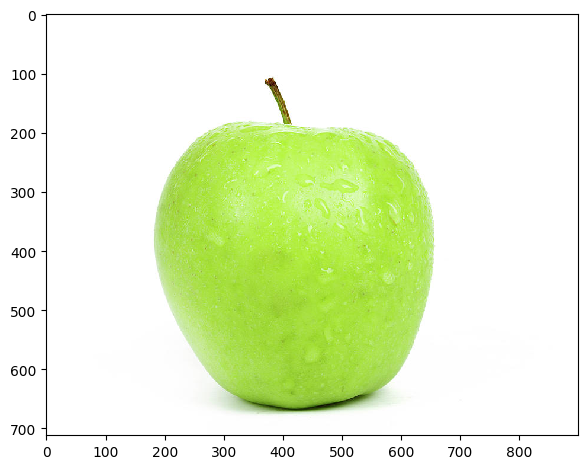

In [52]:
sample_image = imread("data/ColorfulOriginal/Apple/Apple1.jpg")/255
imshow(sample_image)

sample_image = tf.convert_to_tensor(sample_image, dtype=tf.float32)
#print(sample_image)
sample_image = tfio.experimental.color.rgb_to_lab(sample_image)
#print(sample_image)
print(tf.reduce_min(sample_image[0]), tf.reduce_max(sample_image[0]))
print(tf.reduce_min(sample_image[1]), tf.reduce_max(sample_image[1]))
print(tf.reduce_min(sample_image[2]), tf.reduce_max(sample_image[2]))

In [64]:
  
def visualize(predicted_color, predicted_label, data):
    images = data[0]
    labels = data[1]
    
    
    grey_images = images[0]
    grey_image = grey_images[0]
    color_images = images[1]
    color_image = color_images[0]
    label = labels[0]


    # manually clipping values, because Lab color space is weird
    predicted_color_lab_scaled = tf.clip_by_value(((predicted_color - [0.5, 0.5]) * [200, 200]), -100, 100)
    color_image_lab_scaled = tf.clip_by_value(((color_image - [0.5, 0.5]) * [200, 200]), -100, 100)
    greyscale =tf.squeeze((grey_image - [0.5]) * [200], axis=-1)

    rgb_prediction = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, predicted_color_lab_scaled[:,:,0], predicted_color_lab_scaled[:,:,1]],axis=-1))
    rgb_original = tfio.experimental.color.lab_to_rgb(tf.stack([greyscale, color_image_lab_scaled[:,:,0], color_image_lab_scaled[:,:,1]], axis=-1))

    #labels
    predicted_label = class_names[tf.argmax(predicted_label).numpy()]
    true_label = class_names[tf.argmax(label).numpy()]

    print(predicted_label, true_label)

    fig, ax = plt.subplots(1, 3, figsize = (18, 30))

    greyscale = ((greyscale/200) + 0.5) * 255
    ax[0].imshow(greyscale, cmap="gist_gray") 
    ax[0].axis('off')
    ax[0].set_title('greyscale')

    ax[1].imshow(rgb_prediction) 
    ax[1].axis('off')
    ax[1].set_title('pred: ' + predicted_label)
    
    ax[2].imshow(rgb_original) 
    ax[2].axis('off')
    ax[2].set_title('orig: ' + true_label)


    
    
   

In [65]:
# training loop

# log results with tensorboard 
# save model to be able to reuse it

def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color, predicted_label = model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            tf.summary.scalar(model.metrics[3].name, model.metrics[3].result(), step=epoch)

            
            
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Train)")
        print("Top-5-Accuracy: ", model.metrics[3].result().numpy(), "(Train)")


        model.reset_metrics()

        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color, predicted_label = model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            tf.summary.scalar(model.metrics[3].name, model.metrics[3].result(), step=epoch)
                    
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")
        print("Loss Category: ", model.metrics[1].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[2].result().numpy(), "(Test)")
        print("Top-5-Accuracy: ", model.metrics[3].result().numpy(), "(Test)")







In [66]:
def training_loop_colorization(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_color = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_color = model.test_step(data)
            last_data = data


        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            
        print("Loss Color: ", model.metrics[0].result().numpy(), "(Test)")


In [67]:
def training_loop_classification(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range(epochs):
        model.reset_metrics()

        
        for data in tqdm(train_ds, position=0, leave=True):
            predicted_label = model.train_step(data)


        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Train)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Train)")
        print("Top-5-Accuracy: ", model.metrics[2].result().numpy(), "(Train)")

        model.reset_metrics()

        last_data = None
        for data in tqdm(test_ds, position=0, leave=True):
            predicted_label = model.test_step(data)
            last_data = data

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
            tf.summary.scalar(model.metrics[2].name, model.metrics[2].result(), step=epoch)
            
        print("Loss Category: ", model.metrics[0].result().numpy(), "(Test)")
        print("Accuracy: ", model.metrics[1].result().numpy(), "(Test)")
        print("Top-5-Accuracy: ", model.metrics[2].result().numpy(), "(Test)")


        print(class_names[tf.argmax(predicted_label[0]).numpy()], 
              class_names[tf.argmax(last_data[1][0]).numpy()])


In [ ]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

no_of_classes = 20
model00001= Model(optimizer=optimizer, loss_function_color=loss_function_color, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/train"
test_log_path = f"logs/{current_time}/colorful/model_BN_DO_GA/Adam0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop(model00001, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


 60%|██████    | 3/5 [00:00<00:00, 12.71it/s]

Strawberry Strawberry
Apple Tomato
Pomegranate Tomato
Strawberry Strawberry


100%|██████████| 5/5 [00:00<00:00, 13.91it/s]


Strawberry Strawberry


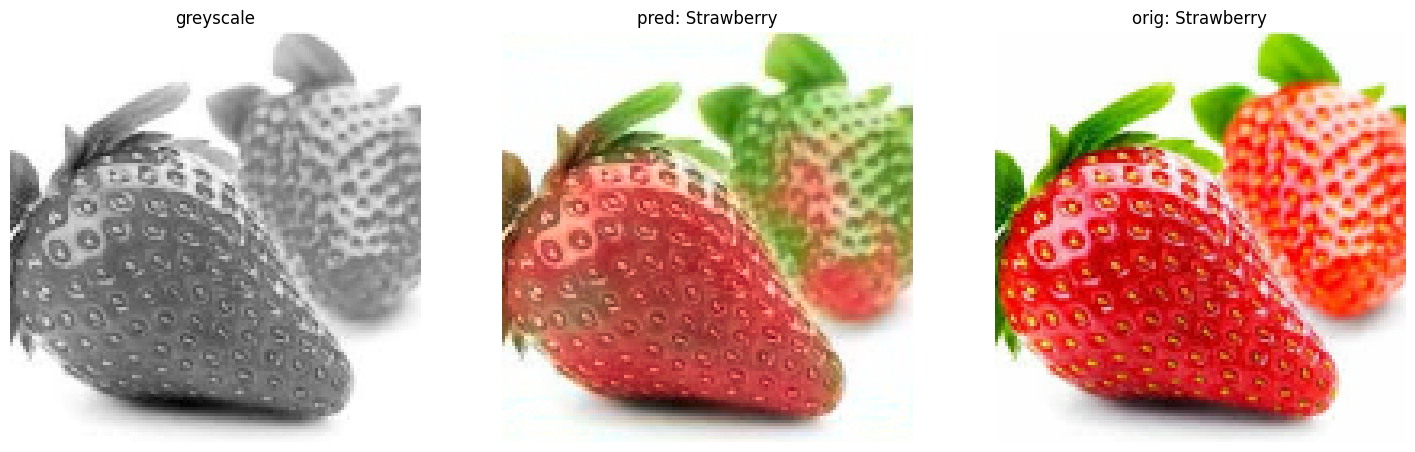

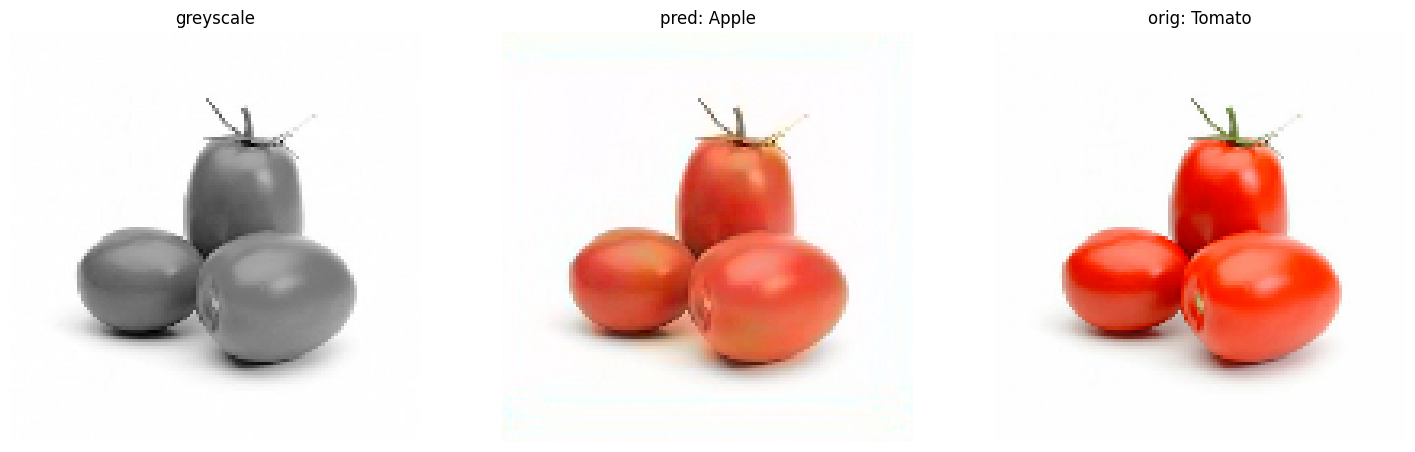

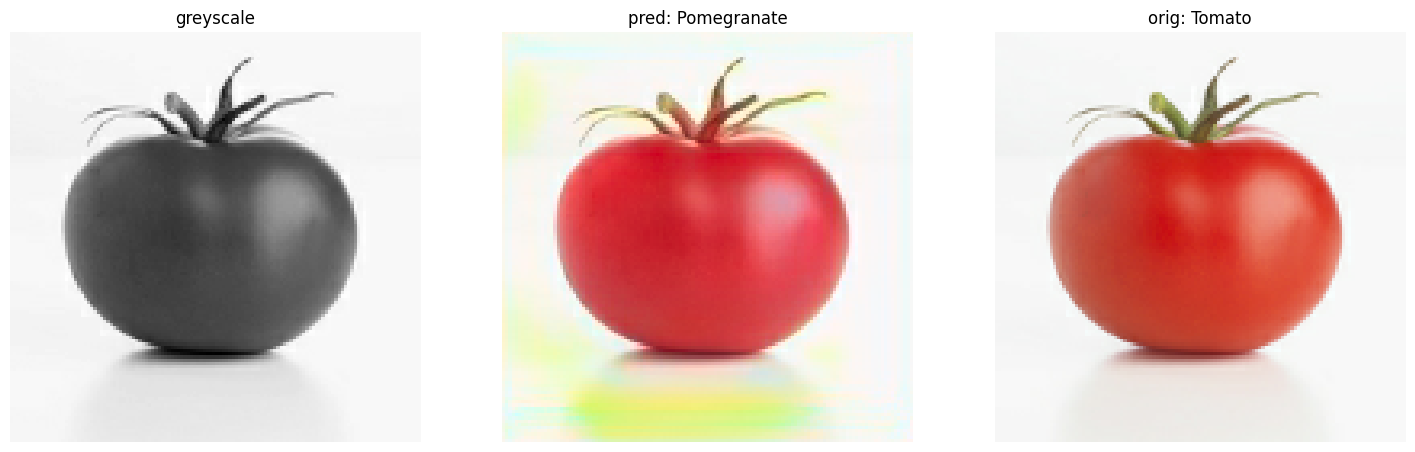

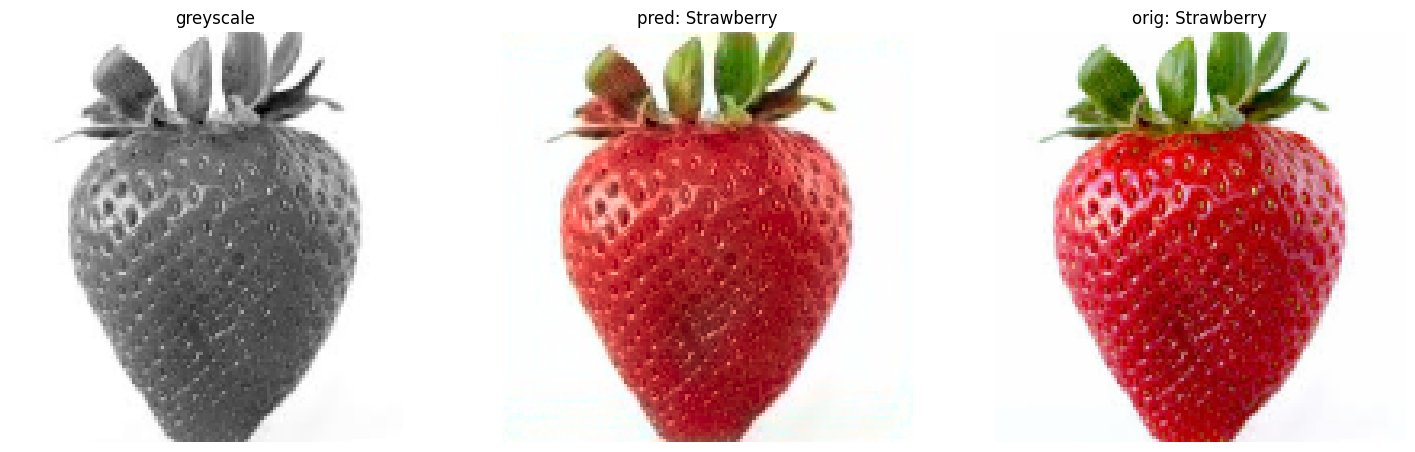

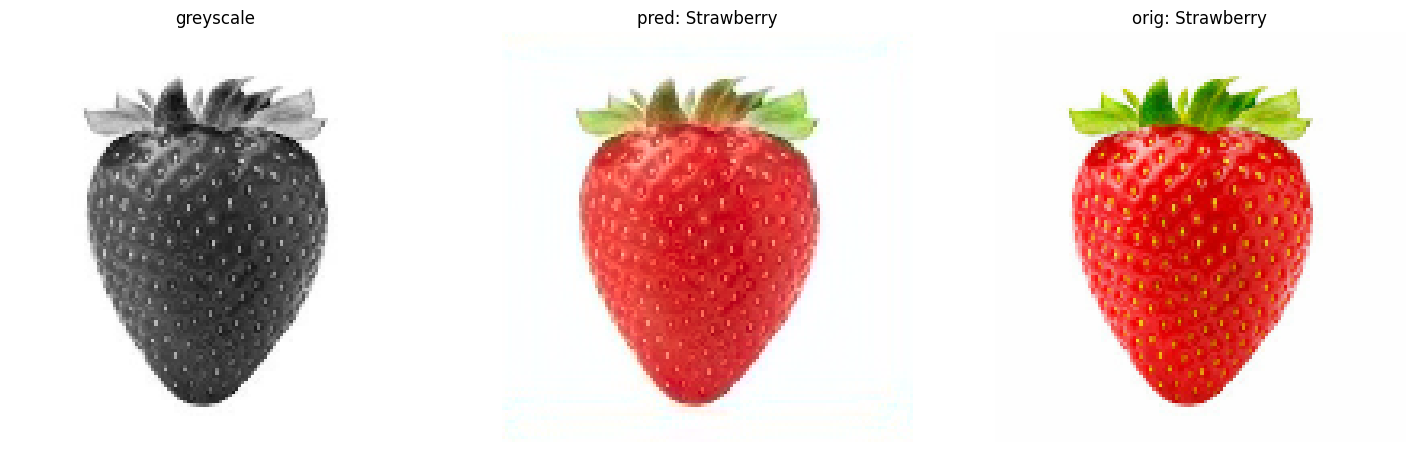

In [69]:
for data in tqdm(test_data, position=0, leave=True):
    predicted_color, predicted_label = model00001.test_step(data)

    if random.random() < 1:
        visualize(predicted_color[0], predicted_label[0], data)


In [ ]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

no_of_classes = 20
only_classification = Only_Classification_Model(no_of_classes=no_of_classes, optimizer=optimizer, loss_function_category=loss_function_category)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/classification/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/classification/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop_classification(only_classification, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)

In [ ]:
epochs = 500
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
loss_function_color = tf.keras.losses.MeanSquaredError()
loss_function_category = tf.keras.losses.CategoricalCrossentropy()

only_colorization = Only_Colorization_Model(optimizer=optimizer, loss_function_color=loss_function_color)

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{current_time}"
train_log_path = f"logs/colorization/colorful/{current_time}/0.00001/train"
test_log_path = f"logs/colorization/colorful/{current_time}/0.00001/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

training_loop_colorization(only_colorization, train_data, test_data, epochs, train_summary_writer, test_summary_writer, save_path)


100%|██████████| 5/5 [00:00<00:00, 19.57it/s]

Tomato Tomato
Tomato Tomato
Strawberry Strawberry
Tomato Tomato
Tomato Tomato


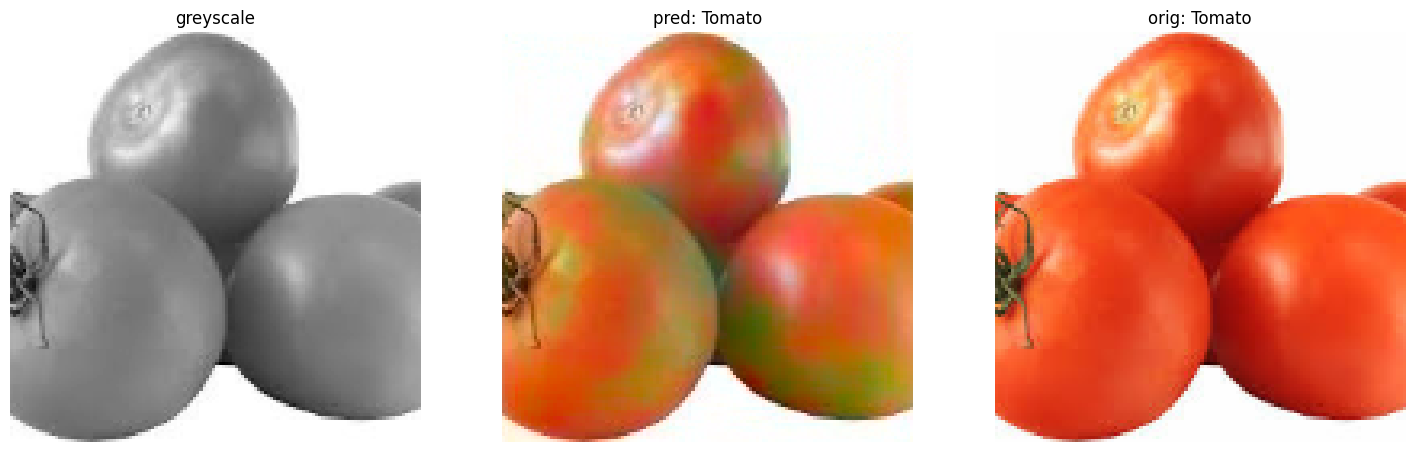

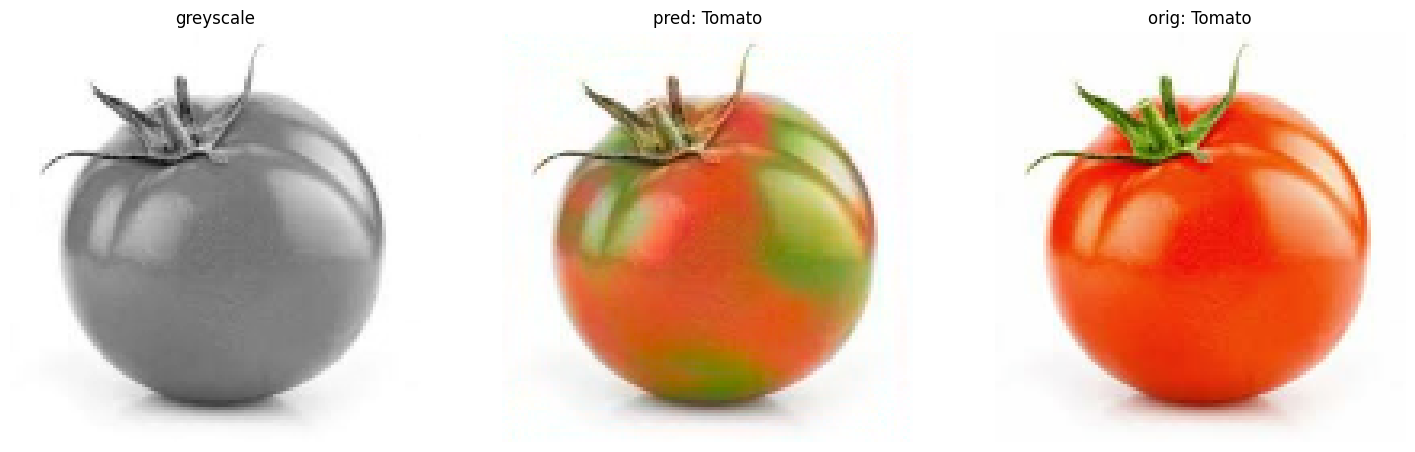

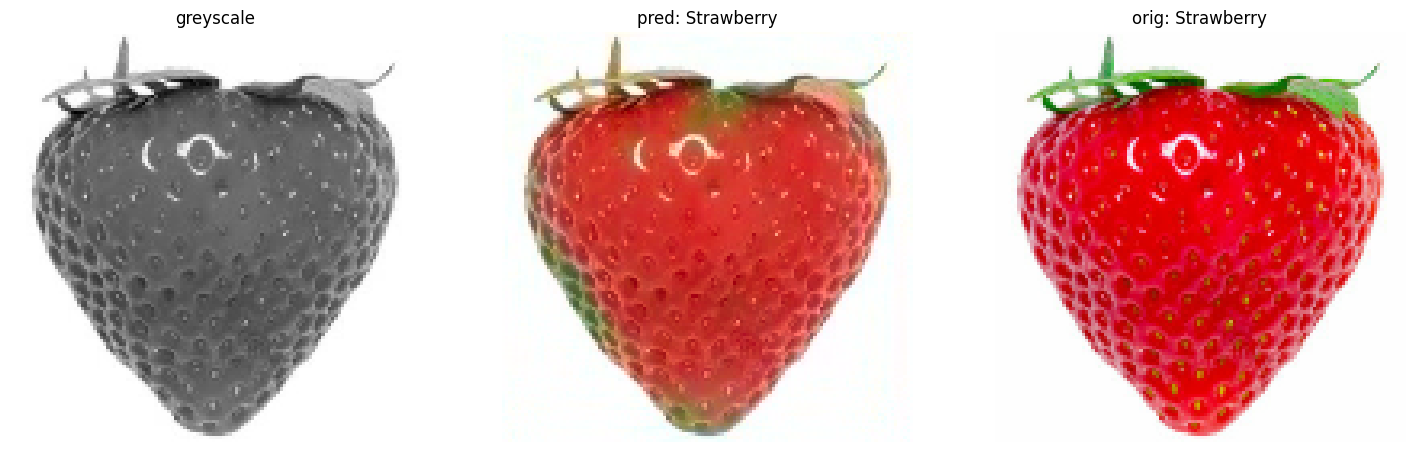

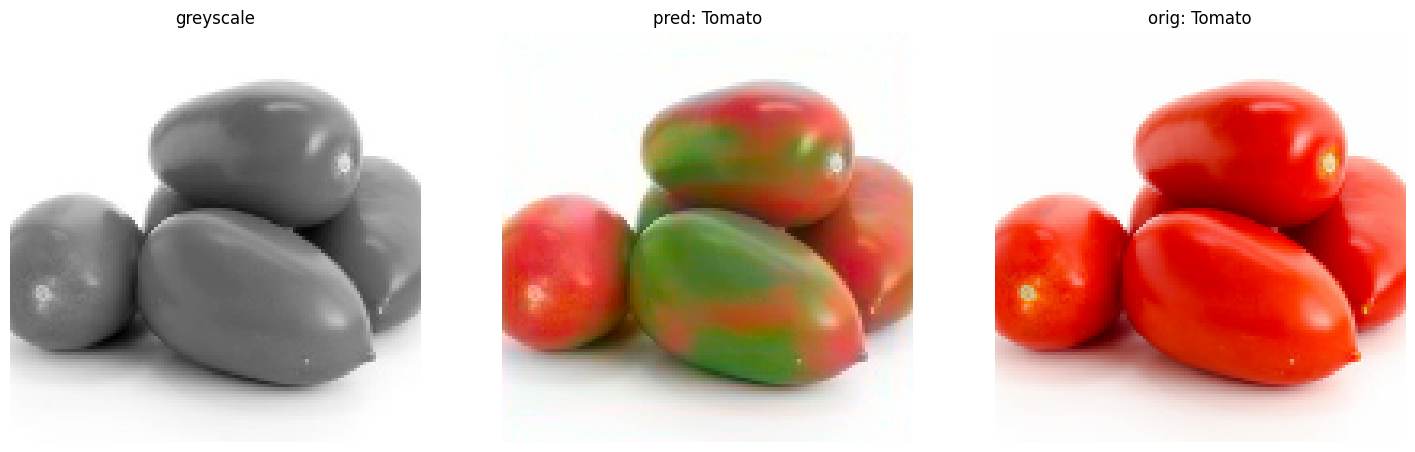

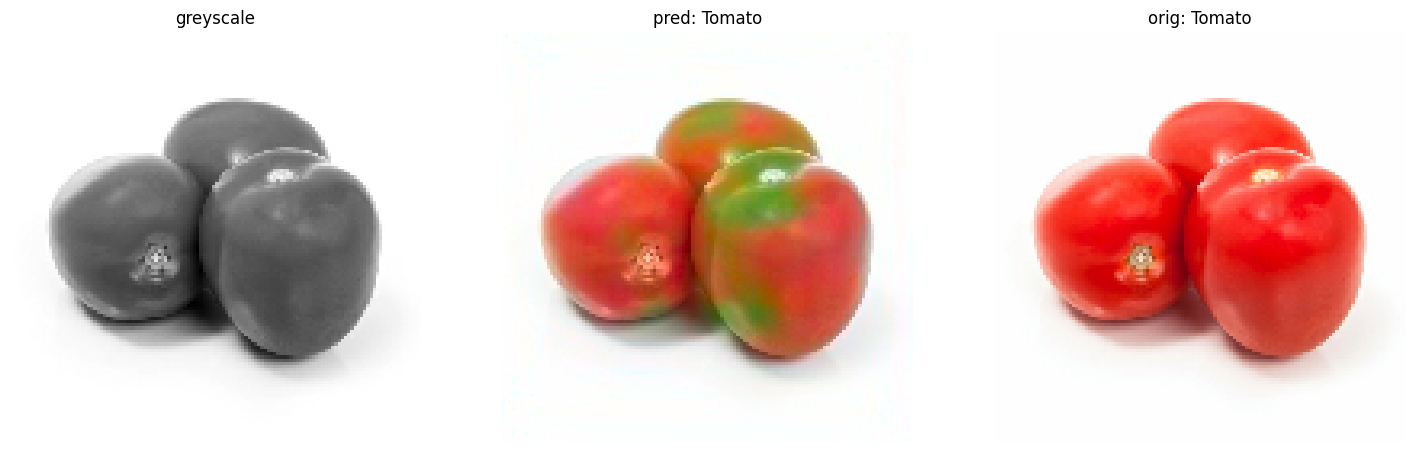

In [74]:
for data in tqdm(test_data, position=0, leave=True):
    predicted_color = only_colorization.test_step(data)

#
    if random.random() < 1:
        visualize(predicted_color[0], data[1][0], data)